In [1]:
import pandas as pd
import tensorflow as tf
data = pd.read_csv('train.csv')

In [36]:
from sklearn.model_selection import train_test_split
X_data = data.drop('label',axis=1)
y_data = data['label']
X_data = X_data/255.0
y_data = y_data
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=0)
X_matrix=X_train.as_matrix()
X_train = X_matrix.reshape(X_matrix.shape[0],28,28,1)
X_matrix=X_test.as_matrix()
X_test = X_matrix.reshape(X_matrix.shape[0],28,28,1)
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
BATCH_SIZE = 128
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = X_train.shape[0]
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = X_test.shape[0]
NUM_CLASSES = 10
SEED = 66478 
NUM_EPOCHS = 10
EVAL_FREQUENCY = 100

In [28]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [33]:
import time
import numpy
import sys
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def train():
    error_mini=[]
    ops.reset_default_graph() 
    train_data_node = tf.placeholder(tf.float32,shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    train_label_node = tf.placeholder(tf.int32,shape=(BATCH_SIZE,))
    eval_data = tf.placeholder(tf.float32,shape=(NUM_EXAMPLES_PER_EPOCH_FOR_EVAL,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS))
    conv1_weights = tf.Variable(tf.truncated_normal([5, 5, NUM_CHANNELS, 32],stddev=0.1,seed=SEED, dtype=tf.float32))
    conv1_biases = tf.Variable(tf.zeros([32], dtype=tf.float32))
    conv2_weights = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1,seed=SEED, dtype=tf.float32))
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=tf.float32))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                                                  stddev=0.1,seed=SEED,dtype=tf.float32))
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=tf.float32))
    fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_CLASSES],
                                                    stddev=0.1,
                                                    seed=SEED,
                                                    dtype=tf.float32))
    fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES], dtype=tf.float32))
    num_epochs = NUM_EPOCHS
    train_size = X_train.shape[0]

    def model(data, train=False):
        """The Model definition."""
        # 2D convolution, with 'SAME' padding (i.e. the output feature map has
        # the same size as the input). Note that {strides} is a 4D array whose
        # shape matches the data layout: [image index, y, x, depth].
        conv = tf.nn.conv2d(data,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        # Bias and rectified linear non-linearity.
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        # Max pooling. The kernel size spec {ksize} also follows the layout of
        # the data. Here we have a pooling window of 2, and a stride of 2.
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        conv = tf.nn.conv2d(pool,
                            conv2_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        # Reshape the feature map cuboid into a 2D matrix to feed it to the
        # fully connected layers.
        pool_shape = pool.get_shape().as_list()
        reshape = tf.reshape(
            pool,
            [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        # Add a 50% dropout during training only. Dropout also scales
        # activations such that no rescaling is needed at evaluation time.
        if train:
          hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases

      # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=train_label_node))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                  tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers

    # Optimizer: set up a variable that's incremented once per batch and
    # controls the learning rate decay.
    batch = tf.Variable(0, dtype=tf.float32)
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(
        0.01,                # Base learning rate.
        batch * BATCH_SIZE,  # Current index into the dataset.
        train_size,          # Decay step.
        0.95,                # Decay rate.
        staircase=True)
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(loss,global_step=batch)
    # Predictions for the current training minibatch.
    train_prediction = tf.nn.softmax(logits)

    # Predictions for the test and validation, which we'll compute less often.
    eval_prediction = tf.nn.softmax(model(eval_data))
    #  Create a local session to run the training.
    start_time = time.time()
    with tf.Session() as sess:
        # Run all the initializers to prepare the trainable parameters.
        init = tf.global_variables_initializer()
        sess.run(init)
        print('Initialized!')
        # Loop through training steps.
        for step in xrange(int(num_epochs * train_size) // BATCH_SIZE):
              # Compute the offset of the current minibatch in the data.
              # Note that we could use better randomization across epochs.
            offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
            batch_data = X_train[offset:(offset + BATCH_SIZE),:]
            batch_labels = y_train[offset:(offset + BATCH_SIZE)]
            # This dictionary maps the batch data (as a numpy array) to the
            # node in the graph it should be fed to.
            feed_dict = {train_data_node: batch_data,
                         train_label_node: batch_labels}
            # Run the optimizer to update weights.
            sess.run(optimizer, feed_dict=feed_dict)
            # print some extra information once reach the evaluation frequency
            if step % EVAL_FREQUENCY == 0:
                
              # fetch some extra nodes' data
                l, lr, predictions = sess.run([loss, learning_rate, train_prediction],
                                            feed_dict=feed_dict)
                elapsed_time = time.time() - start_time
                start_time = time.time()
                print('Step %d (epoch %.2f), %.1f ms' %
                      (step, float(step) * BATCH_SIZE / train_size,
                       1000 * elapsed_time /EVAL_FREQUENCY))
                print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
                print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
                error_mini.append(error_rate(predictions, batch_labels))
        plt.plot(numpy.squeeze(error_mini))
        plt.ylabel('error mini')
        plt.xlabel('iterations (per hundreds)')
        plt.show()
        test_pr = sess.run(eval_prediction,feed_dict={ eval_data:X_test})
        print('eval error: %.1f%%'%error_rate(test_pr,y_test))

In [26]:
X_train.shape

(33600, 28, 28, 1)

Initialized!
Step 0 (epoch 0.00), 4.9 ms
Minibatch loss: 7.826, learning rate: 0.010000
Minibatch error: 84.4%
Step 100 (epoch 0.38), 601.1 ms
Minibatch loss: 3.365, learning rate: 0.010000
Minibatch error: 8.6%
Step 200 (epoch 0.76), 582.1 ms
Minibatch loss: 3.265, learning rate: 0.010000
Minibatch error: 6.2%
Step 300 (epoch 1.14), 654.8 ms
Minibatch loss: 3.122, learning rate: 0.009500
Minibatch error: 1.6%
Step 400 (epoch 1.52), 694.5 ms
Minibatch loss: 3.195, learning rate: 0.009500
Minibatch error: 7.0%
Step 500 (epoch 1.90), 682.6 ms
Minibatch loss: 3.177, learning rate: 0.009500
Minibatch error: 2.3%
Step 600 (epoch 2.29), 674.0 ms
Minibatch loss: 3.026, learning rate: 0.009025
Minibatch error: 1.6%
Step 700 (epoch 2.67), 756.7 ms
Minibatch loss: 2.977, learning rate: 0.009025
Minibatch error: 1.6%
Step 800 (epoch 3.05), 770.6 ms
Minibatch loss: 2.933, learning rate: 0.008574
Minibatch error: 2.3%
Step 900 (epoch 3.43), 739.7 ms
Minibatch loss: 3.088, learning rate: 0.008574
Mi

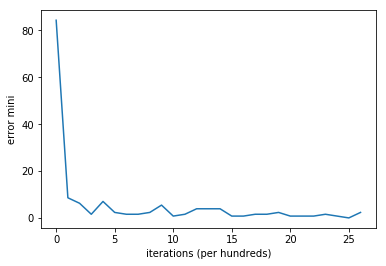

eval error: 1.4%


In [38]:
train()